# 图像风格迁移模型-CycleGAN

作者：[FutureSI](https://github.com/ctkindle)

日期：2020/10/24

## CycleGAN介绍
CycleGAN，即循环生成对抗网络，是一种用于图片风格迁移的模型。原来的图片风格迁移模型通过在两组一一匹配的图片进行上训练，来学习输入图片组与输出图片组的特征映射关系，从而实现将输入图片的特征迁移到输出图片上，比如将A组图片的斑马的条纹外观特征迁移到B组普通马匹图片上。但是，训练所要求的两组一一对应训练集图片往往难以获得。CycleGAN通过给GAN网络添加循环一致性损失（consistency loss）的方法打破了训练集图片数据的一一对应限制。
* 论文原文：[Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf)
* 论文原版代码：[https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)

## 框架导入设置

In [1]:
# # 解压 ai studio 数据集（首次执行后注释）
# !unzip -qa -d /home/aistudio/data/data10040/ /home/aistudio/data/data10040/horse2zebra.zip

# # # 如果用wget自行下载数据集需要自行添加训练集列表文件
# # !wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip 
# # !unzip -qa -d /home/aistudio/data/data10040/ horse2zebra.zip

In [3]:
import paddle
from paddle.io import Dataset, DataLoader, IterableDataset
import numpy as np
import cv2
import random
import time
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore", category=Warning) # 过滤报警信息

BATCH_SIZE = 1
DATA_DIR = '/home/aistudio/data/data10040/horse2zebra/' # 设置训练集数据地址
# PLACE = paddle.CPUPlace() # 在cpu上训练
PLACE = paddle.CUDAPlace(0)  # 在gpu上训练

## 准备数据集

In [4]:
from PIL import Image
from paddle.vision.transforms import RandomCrop

# 处理图片数据：随机裁切、调整图片数据形状、归一化数据
def data_transform(img, output_size):
    h, w, _ = img.shape
    assert h == w and h >= output_size # check picture size
    # random crop
    rc = RandomCrop(224)
    img = rc(img)
    # normalize
    img = img / 255. * 2. - 1.
    # from [H,W,C] to [C,H,W]
    img = np.transpose(img, (2, 0, 1))
    # data type
    img = img.astype('float32')    
    return img

# 定义horse2zebra数据集对象
class H2ZDateset(Dataset):
    def __init__(self, data_dir):
        super(H2ZDateset, self).__init__()
        self.data_dir = data_dir
        self.pic_list_a = np.loadtxt(data_dir+'trainA.txt', dtype=np.str)
        np.random.shuffle(self.pic_list_a)
        self.pic_list_b = np.loadtxt(data_dir+'trainB.txt', dtype=np.str)
        np.random.shuffle(self.pic_list_b)
        self.pic_list_lenth = min(int(self.pic_list_a.shape[0]), int(self.pic_list_b.shape[0]))

    def __getitem__(self, idx):
        img_dir_a = self.data_dir+self.pic_list_a[idx]
        img_a = cv2.imread(img_dir_a)
        img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
        img_a = data_transform(img_a, 224)
        img_dir_b = self.data_dir+self.pic_list_b[idx]
        img_b = cv2.imread(img_dir_b)
        img_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB)
        img_b = data_transform(img_b, 224)
        return np.array([img_a, img_b])

    def __len__(self):
        return self.pic_list_lenth

# 定义图片loader
h2zdateset = H2ZDateset(DATA_DIR)
loader = DataLoader(h2zdateset, places=PLACE, shuffle=True, batch_size=BATCH_SIZE, drop_last=False, num_workers=0, use_shared_memory=False)
data = next(loader())[0]
data = np.transpose(data, (1, 0, 2, 3, 4))
print("读取的数据形状：", data.shape)


读取的数据形状： [2, 1, 3, 224, 224]


## 定义辅助功能函数
判别器负责区分图片的“真假”。输入的是训练集图片，判别器的输出越趋近于数值1（即判别此图片为真)；如果输入的是生成器生成的图片，判别器的输出越趋近于数值0（即判别此图片为假)。这样，生成器就可以根据判别器输出的变化而计算梯度以优化生成网络。

In [16]:
from PIL import Image
import os

# 打开图片
def open_pic(file_name='./data/data10040/horse2zebra/testA/n02381460_1300.jpg'):
    img = Image.open(file_name).resize((256, 256), Image.BILINEAR)
    img = (np.array(img).astype('float32') / 255.0 - 0.5) / 0.5
    img = img.transpose((2, 0, 1))
    img = img.reshape((-1, img.shape[0], img.shape[1], img.shape[2]))
    return img

# 存储图片
def save_pics(pics, file_name='tmp', save_path='./output/pics/', save_root_path='./output/'):
    if not os.path.exists(save_root_path):
        os.makedirs(save_root_path)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for i in range(len(pics)):
        pics[i] = pics[i][0]
    pic = np.concatenate(tuple(pics), axis=2)
    pic = pic.transpose((1,2,0))
    pic = (pic + 1) / 2
    # plt.imshow(pic)
    pic = np.clip(pic * 256, 0, 255)
    img = Image.fromarray(pic.astype('uint8')).convert('RGB')
    img.save(save_path+file_name+'.jpg')
    
# 显示图片
def show_pics(pics):
    print(pics[0].shape)
    plt.figure(figsize=(3 * len(pics), 3), dpi=80)
    for i in range(len(pics)):
        pics[i] = (pics[i][0].transpose((1,2,0)) + 1) / 2
        plt.subplot(1, len(pics), i + 1)
        plt.imshow(pics[i])
        plt.xticks([])
        plt.yticks([])

# 图片缓存队列
class ImagePool(object):
    def __init__(self, pool_size=50):
        self.pool = []
        self.count = 0
        self.pool_size = pool_size
    def pool_image(self, image):
        return image
        image = image.numpy()
        rtn = ''
        if self.count < self.pool_size:
            self.pool.append(image)
            self.count += 1
            rtn = image
        else:
            p = np.random.rand()
            if p > 0.5:
                random_id = np.random.randint(0, self.pool_size - 1)
                temp = self.pool[random_id]
                self.pool[random_id] = image
                rtn = temp
            else:
                rtn = image
        return paddle.to_tensor(rtn)


## 查看读取的数据集图片

(1, 3, 224, 224)


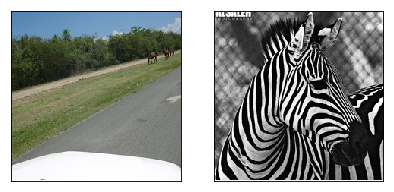

In [17]:
show_pics([data[0].numpy(), data[1].numpy()])

## 定义判别器

In [7]:
import paddle
import paddle.nn as nn
import numpy as np

# 定义基础的“卷积层+实例归一化”块
class ConvIN(nn.Layer):
    def __init__(self, num_channels, num_filters, filter_size, stride=1, padding=1, bias_attr=None, 
        weight_attr=None):
        super(ConvIN, self).__init__()
        model = [
            nn.Conv2D(num_channels, num_filters, filter_size, stride=stride, padding=padding, 
                bias_attr=bias_attr, weight_attr=weight_attr),
            nn.InstanceNorm2D(num_filters),
            nn.LeakyReLU(negative_slope=0.2)
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

# 定义CycleGAN的判别器
class Disc(nn.Layer):
    def __init__(self, weight_attr=nn.initializer.Normal(0., 0.02)):
        super(Disc, self).__init__()
        model = [
            ConvIN(3, 64, 4, stride=2, padding=1, bias_attr=True, weight_attr=weight_attr),
            ConvIN(64, 128, 4, stride=2, padding=1, bias_attr=False, weight_attr=weight_attr),
            ConvIN(128, 256, 4, stride=2, padding=1, bias_attr=False, weight_attr=weight_attr),
            ConvIN(256, 512, 4, stride=1, padding=1, bias_attr=False, weight_attr=weight_attr),
            nn.Conv2D(512, 1, 4, stride=1, padding=1, bias_attr=True, weight_attr=weight_attr)
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)


## 测试判别器模块

In [8]:
ci = ConvIN(3, 3, 3, weight_attr=nn.initializer.Normal(0., 0.02))
logit = ci(paddle.to_tensor(data[0]))
print('ConvIN块输出的特征图形状：', logit.shape)

d = Disc()
logit = d(paddle.to_tensor(data[0]))
print('判别器输出的特征图形状：', logit.shape)



ConvIN块输出的特征图形状： [1, 3, 224, 224]
判别器输出的特征图形状： [1, 1, 26, 26]


## 定义生成器

In [9]:
# 定义基础的“转置卷积层+实例归一化”块
class ConvTransIN(nn.Layer):
    def __init__(self, num_channels, num_filters, filter_size, stride=1, padding='same', padding_mode='constant', 
        bias_attr=None, weight_attr=None):
        super(ConvTransIN, self).__init__()
        model = [
            nn.Conv2DTranspose(num_channels, num_filters, filter_size, stride=stride, padding=padding, 
                bias_attr=bias_attr, weight_attr=weight_attr),
            nn.InstanceNorm2D(num_filters),
            nn.LeakyReLU(negative_slope=0.2)
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

# 定义残差块
class Residual(nn.Layer):
    def __init__(self, dim, bias_attr=None, weight_attr=None):
        super(Residual, self).__init__()
        model = [
            nn.Conv2D(dim, dim, 3, stride=1, padding=1, padding_mode='reflect', bias_attr=bias_attr, 
                weight_attr=weight_attr),
            nn.InstanceNorm2D(dim),
            nn.LeakyReLU(negative_slope=0.2),
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return x + self.model(x)

# 定义CycleGAN的生成器
class Gen(nn.Layer):
    def __init__(self, base_dim=64, residual_num=7, downup_layer=2, weight_attr=nn.initializer.Normal(0., 0.02)):
        super(Gen, self).__init__()
        model=[
            nn.Conv2D(3, base_dim, 7, stride=1, padding=3, padding_mode='reflect', bias_attr=False, 
                weight_attr=weight_attr),
            nn.InstanceNorm2D(base_dim),
            nn.LeakyReLU(negative_slope=0.2)
        ]
        # 下采样块（down sampling）
        for i in range(downup_layer):
            model += [
                ConvIN(base_dim * 2 ** i, base_dim * 2 ** (i + 1), 3, stride=2, padding=1, bias_attr=False, 
                    weight_attr=weight_attr),
            ]
        # 残差块（residual blocks）
        for i in range(residual_num):
            model += [
                Residual(base_dim * 2 ** downup_layer, True, weight_attr=nn.initializer.Normal(0., 0.02))
            ]
        # 上采样块（up sampling）
        for i in range(downup_layer):
            model += [
                ConvTransIN(base_dim * 2 ** (downup_layer - i), base_dim * 2 ** (downup_layer - i - 1), 3, 
                    stride=2, padding='same', padding_mode='constant', bias_attr=False, weight_attr=weight_attr),
            ]
        model += [
            nn.Conv2D(base_dim, 3, 7, stride=1, padding=3, padding_mode='reflect', bias_attr=True, 
                weight_attr=nn.initializer.Normal(0., 0.02)),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)


## 测试生成器模块

In [10]:
cti = ConvTransIN(3, 3, 3, stride=2, padding='same', padding_mode='constant', bias_attr=False, 
    weight_attr=nn.initializer.Normal(0., 0.02))
logit = cti(paddle.to_tensor(data[0]))
print('ConvTransIN块输出的特征图形状：', logit.shape)

r = Residual(3, True, weight_attr=nn.initializer.Normal(0., 0.02))
logit = r(paddle.to_tensor(data[0]))
print('Residual块输出的特征图形状：', logit.shape)

g = Gen()
logit = g(paddle.to_tensor(data[0]))
print('生成器输出的特征图形状：', logit.shape)


ConvTransIN块输出的特征图形状： [1, 3, 448, 448]
Residual块输出的特征图形状： [1, 3, 224, 224]
生成器输出的特征图形状： [1, 3, 224, 224]


## 训练CycleGAN网络

Start time : 2021-01-29 12:17:20 start step: 134011
[134011] DA: [0.34684318] DB: [0.03796714] GA: [2.1558414] GB: [2.6736887] 2021-01-29 12:17:20
(1, 3, 224, 224)
(1, 3, 224, 224)
[134012] DA: [0.26113242] DB: [0.16278833] GA: [2.2483673] GB: [1.997791] 2021-01-29 12:17:21
(1, 3, 224, 224)
(1, 3, 224, 224)
[134013] DA: [0.27509353] DB: [0.19597135] GA: [1.7526001] GB: [1.7927443] 2021-01-29 12:17:21
(1, 3, 224, 224)
(1, 3, 224, 224)
[134014] DA: [0.2525898] DB: [0.11468825] GA: [2.146185] GB: [2.116558] 2021-01-29 12:17:21
(1, 3, 224, 224)
(1, 3, 224, 224)
[134015] DA: [0.08338843] DB: [0.21931437] GA: [2.460684] GB: [1.974128] 2021-01-29 12:17:22
(1, 3, 224, 224)
(1, 3, 224, 224)
End time : 2021-01-29 12:17:23 End Step: 134015


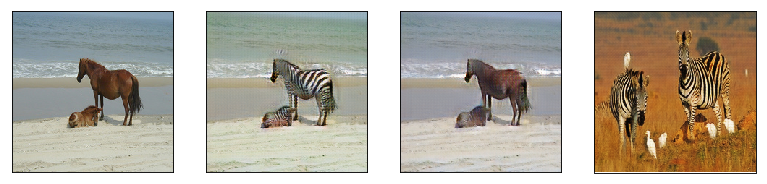

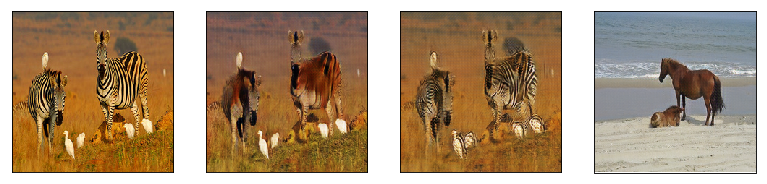

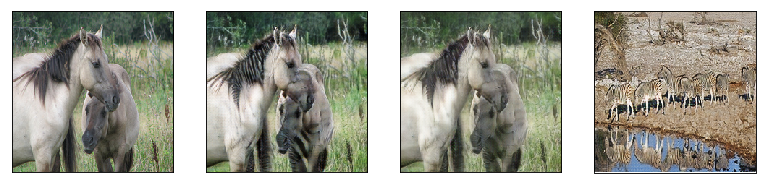

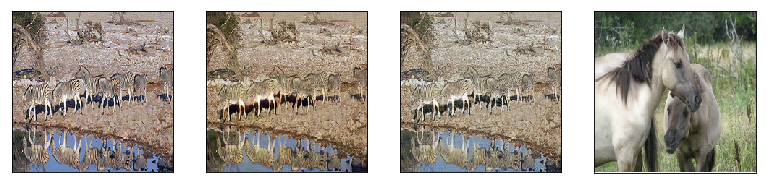

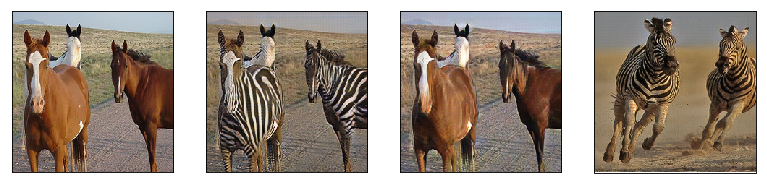

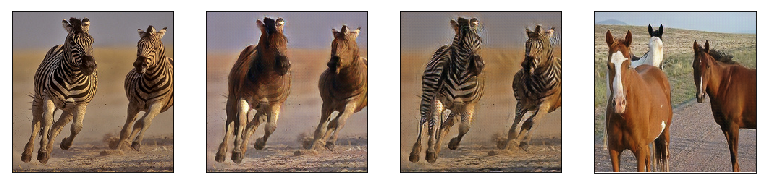

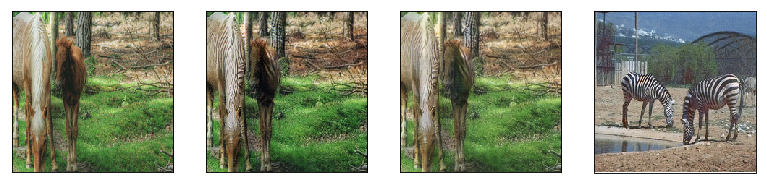

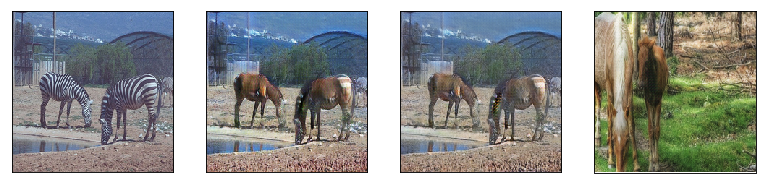

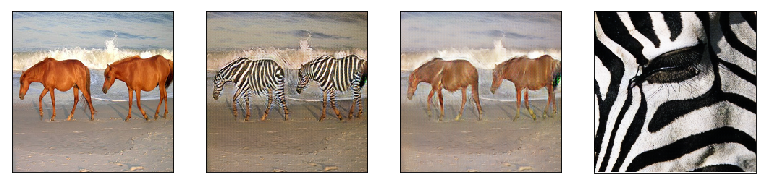

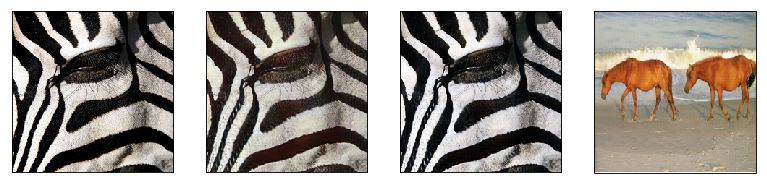

In [18]:
# 模型训练函数
def train(place, epoch_num=99999, adv_weight=1, cycle_weight=10, identity_weight=10, \
          load_model=False, model_path='./model/', model_path_bkp='./model_bkp/', \
          print_interval=1, max_step=5, model_bkp_interval=2000):

    # 定义两对生成器、判别器对象
    g_a = Gen()
    g_b = Gen()
    d_a = Disc()
    d_b = Disc()

    # 定义数据读取器
    dataset = H2ZDateset(DATA_DIR)
    reader_ab = DataLoader(dataset, places=PLACE, shuffle=True, batch_size=BATCH_SIZE, drop_last=False, 
        num_workers=2)

    # 定义优化器
    g_a_optimizer = paddle.optimizer.Adam(learning_rate=0.0002, beta1=0.5, beta2=0.999, parameters=g_a.parameters())
    g_b_optimizer = paddle.optimizer.Adam(learning_rate=0.0002, beta1=0.5, beta2=0.999, parameters=g_b.parameters())
    d_a_optimizer = paddle.optimizer.Adam(learning_rate=0.0002, beta1=0.5, beta2=0.999, parameters=d_a.parameters())
    d_b_optimizer = paddle.optimizer.Adam(learning_rate=0.0002, beta1=0.5, beta2=0.999, parameters=d_b.parameters())

    # 定义图片缓存队列
    fa_pool, fb_pool = ImagePool(), ImagePool()

    # 定义总迭代次数为0
    total_step_num = np.array([0])

    # 加载存储的模型
    if load_model == True:
        ga_para_dict = paddle.load(model_path+'gen_b2a.pdparams')
        g_a.set_state_dict(ga_para_dict)

        gb_para_dict = paddle.load(model_path+'gen_a2b.pdparams')
        g_b.set_state_dict(gb_para_dict)

        da_para_dict = paddle.load(model_path+'dis_ga.pdparams')
        d_a.set_state_dict(da_para_dict)

        db_para_dict = paddle.load(model_path+'dis_gb.pdparams')
        d_b.set_state_dict(db_para_dict)

        total_step_num = np.load('./model/total_step_num.npy')
    
    # 定义本次训练开始时的迭代次数
    step = total_step_num[0]

    # 开始模型训练循环
    print('Start time :', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), 'start step:', step + 1)
    for epoch in range(epoch_num):
        for data_ab in reader_ab:
            step += 1

            # 设置模型为训练模式，针对bn、dropout等进行不同处理
            g_a.train()
            g_b.train()
            d_a.train()
            d_b.train()

            # 得到A、B组图片数据
            data_ab = np.transpose(data_ab[0], (1, 0, 2, 3, 4))
            img_ra = paddle.to_tensor(data_ab[0])
            img_rb = paddle.to_tensor(data_ab[1])

            # 训练判别器DA
            d_loss_ra = paddle.mean((d_a(img_ra.detach()) - 1) ** 2)
            d_loss_fa = paddle.mean(d_a(fa_pool.pool_image(g_a(img_rb.detach()))) ** 2)
            da_loss = (d_loss_ra + d_loss_fa) * 0.5
            da_loss.backward() # 反向更新梯度
            d_a_optimizer.step() # 更新模型权重
            d_a_optimizer.clear_grad() # 清除梯度

            # 训练判别器DB
            d_loss_rb = paddle.mean((d_b(img_rb.detach()) - 1) ** 2)
            d_loss_fb = paddle.mean(d_b(fb_pool.pool_image(g_b(img_ra.detach()))) ** 2)
            db_loss = (d_loss_rb + d_loss_fb) * 0.5
            db_loss.backward()
            d_b_optimizer.step()
            d_b_optimizer.clear_grad()

            # 训练生成器GA
            ga_gan_loss = paddle.mean((d_a(g_a(img_rb.detach())) - 1) ** 2)
            ga_cyc_loss = paddle.mean(paddle.abs(img_rb.detach() - g_b(g_a(img_rb.detach()))))
            ga_ide_loss = paddle.mean(paddle.abs(img_ra.detach() - g_a(img_ra.detach())))
            ga_loss = ga_gan_loss * adv_weight + ga_cyc_loss * cycle_weight + ga_ide_loss * identity_weight
            ga_loss.backward()
            g_a_optimizer.step()
            g_a_optimizer.clear_grad()

            # 训练生成器GB
            gb_gan_loss = paddle.mean((d_b(g_b(img_ra.detach())) - 1) ** 2)
            gb_cyc_loss = paddle.mean(paddle.abs(img_ra.detach() - g_a(g_b(img_ra.detach()))))
            gb_ide_loss = paddle.mean(paddle.abs(img_rb.detach() - g_b(img_rb.detach())))
            gb_loss = gb_gan_loss * adv_weight + gb_cyc_loss * cycle_weight + gb_ide_loss * identity_weight
            gb_loss.backward()
            g_b_optimizer.step()
            g_b_optimizer.clear_grad()
            
            # 存储训练过程中生成的图片
            if step in range(1, 101):
                pic_save_interval = 1
            elif step in range(101, 1001):
                pic_save_interval = 10
            elif step in range(1001, 10001):
                pic_save_interval = 100
            else:
                pic_save_interval = 500
            if step % pic_save_interval == 0:
                save_pics([img_ra.numpy(), g_b(img_ra).numpy(), g_a(g_b(img_ra)).numpy(), g_b(img_rb).numpy(), \
                            img_rb.numpy(), g_a(img_rb).numpy(), g_b(g_a(img_rb)).numpy(), g_a(img_ra).numpy()], \
                            str(step))
                test_pic = open_pic()
                test_pic_pp = paddle.to_tensor(test_pic)
                save_pics([test_pic, g_b(test_pic_pp).numpy()], str(step), save_path='./output/pics_test/')

            # 打印训练过程中的loss值和生成的图片
            if step % print_interval == 0:
                print([step], \
                        'DA:', da_loss.numpy(), \
                        'DB:', db_loss.numpy(), \
                        'GA:', ga_loss.numpy(), \
                        'GB:', gb_loss.numpy(), \
                        time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
                show_pics([img_ra.numpy(), g_b(img_ra).numpy(), g_a(g_b(img_ra)).numpy(), g_b(img_rb).numpy()])
                show_pics([img_rb.numpy(), g_a(img_rb).numpy(), g_b(g_a(img_rb)).numpy(), g_a(img_ra).numpy()])

            # 定期备份模型
            if step % model_bkp_interval == 0:
                paddle.save(g_a.state_dict(), model_path_bkp+'gen_b2a.pdparams')
                paddle.save(g_b.state_dict(), model_path_bkp+'gen_a2b.pdparams')
                paddle.save(d_a.state_dict(), model_path_bkp+'dis_ga.pdparams')
                paddle.save(d_b.state_dict(), model_path_bkp+'dis_gb.pdparams')
                np.save(model_path_bkp+'total_step_num', np.array([step]))

            # 完成训练时存储模型
            if step >= max_step + total_step_num[0]:
                paddle.save(g_a.state_dict(), model_path+'gen_b2a.pdparams')
                paddle.save(g_b.state_dict(), model_path+'gen_a2b.pdparams')
                paddle.save(d_a.state_dict(), model_path+'dis_ga.pdparams')
                paddle.save(d_b.state_dict(), model_path+'dis_gb.pdparams')
                np.save(model_path+'total_step_num', np.array([step]))
                print('End time :', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), 'End Step:', step)
                return

# 从头训练
# train(PLACE)

# 继续训练
train(PLACE, print_interval=1, max_step=5, load_model=True)
# train(PLACE, print_interval=500, max_step=20000, load_model=True)


## 用训练好的模型进行预测

(1, 3, 224, 224) float32
(1, 3, 224, 224)


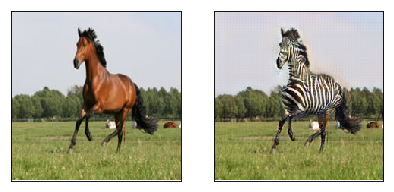

In [19]:
def infer(img_path, place, model_path='./model/'):
    # 定义生成器对象
    g_b = Gen()

    # 设置模型为训练模式，针对bn、dropout等进行不同处理
    g_b.eval()

    # 读取存储的模型
    gb_para_dict = paddle.load(model_path+'gen_a2b.pdparams')
    g_b.set_state_dict(gb_para_dict)
    
    # 读取图片数据
    img_a = cv2.imread(img_path)
    img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
    img_a = data_transform(img_a, 224)
    img_a = paddle.to_tensor(np.array([img_a]))
    
    # 正向计算进行推理
    img_b = g_b(img_a)

    # 打印输出输入、输出图片
    print(img_a.numpy().shape, img_a.numpy().dtype)
    show_pics([img_a.numpy(), img_b.numpy()])

infer('./data/data10040/horse2zebra/testA/n02381460_1300.jpg', PLACE)

